# apply_crf_unet-resnet
forked from apply_crf by NPHard (+0/–0)
需要prediction啊

https://www.kaggle.com/meaninglesslives/apply-crf-unet-resnet

## Loading Necessary Libraries

In [1]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
%matplotlib inline

In [9]:
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(101*101, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(101,101)

## Visualizing some of the predicted masks

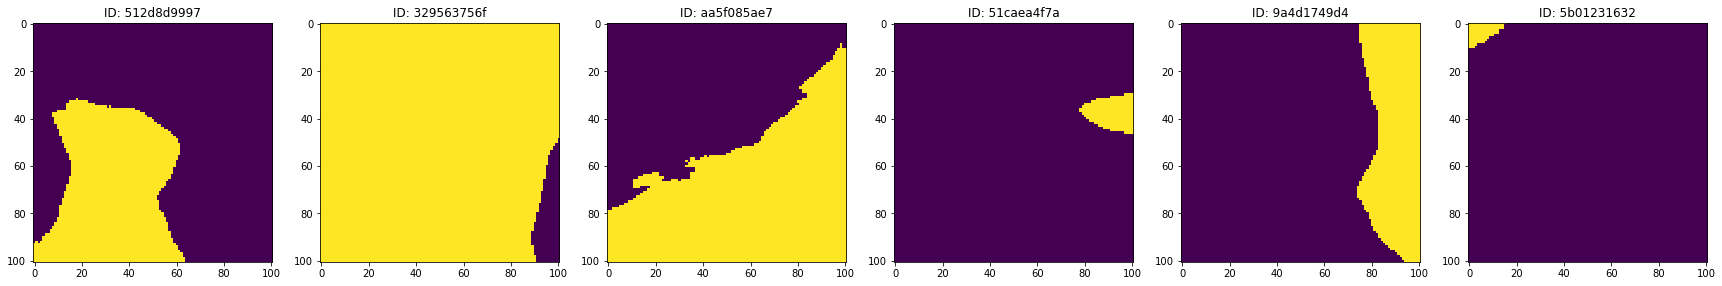

In [14]:
"""
reading and decoding the submission 

"""
df = pd.read_csv('./result/007-submission-vote-fixed.csv')
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

## Visualizing the effect of applying CRF

In [15]:
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [16]:
test_path = "./data/test/images/"

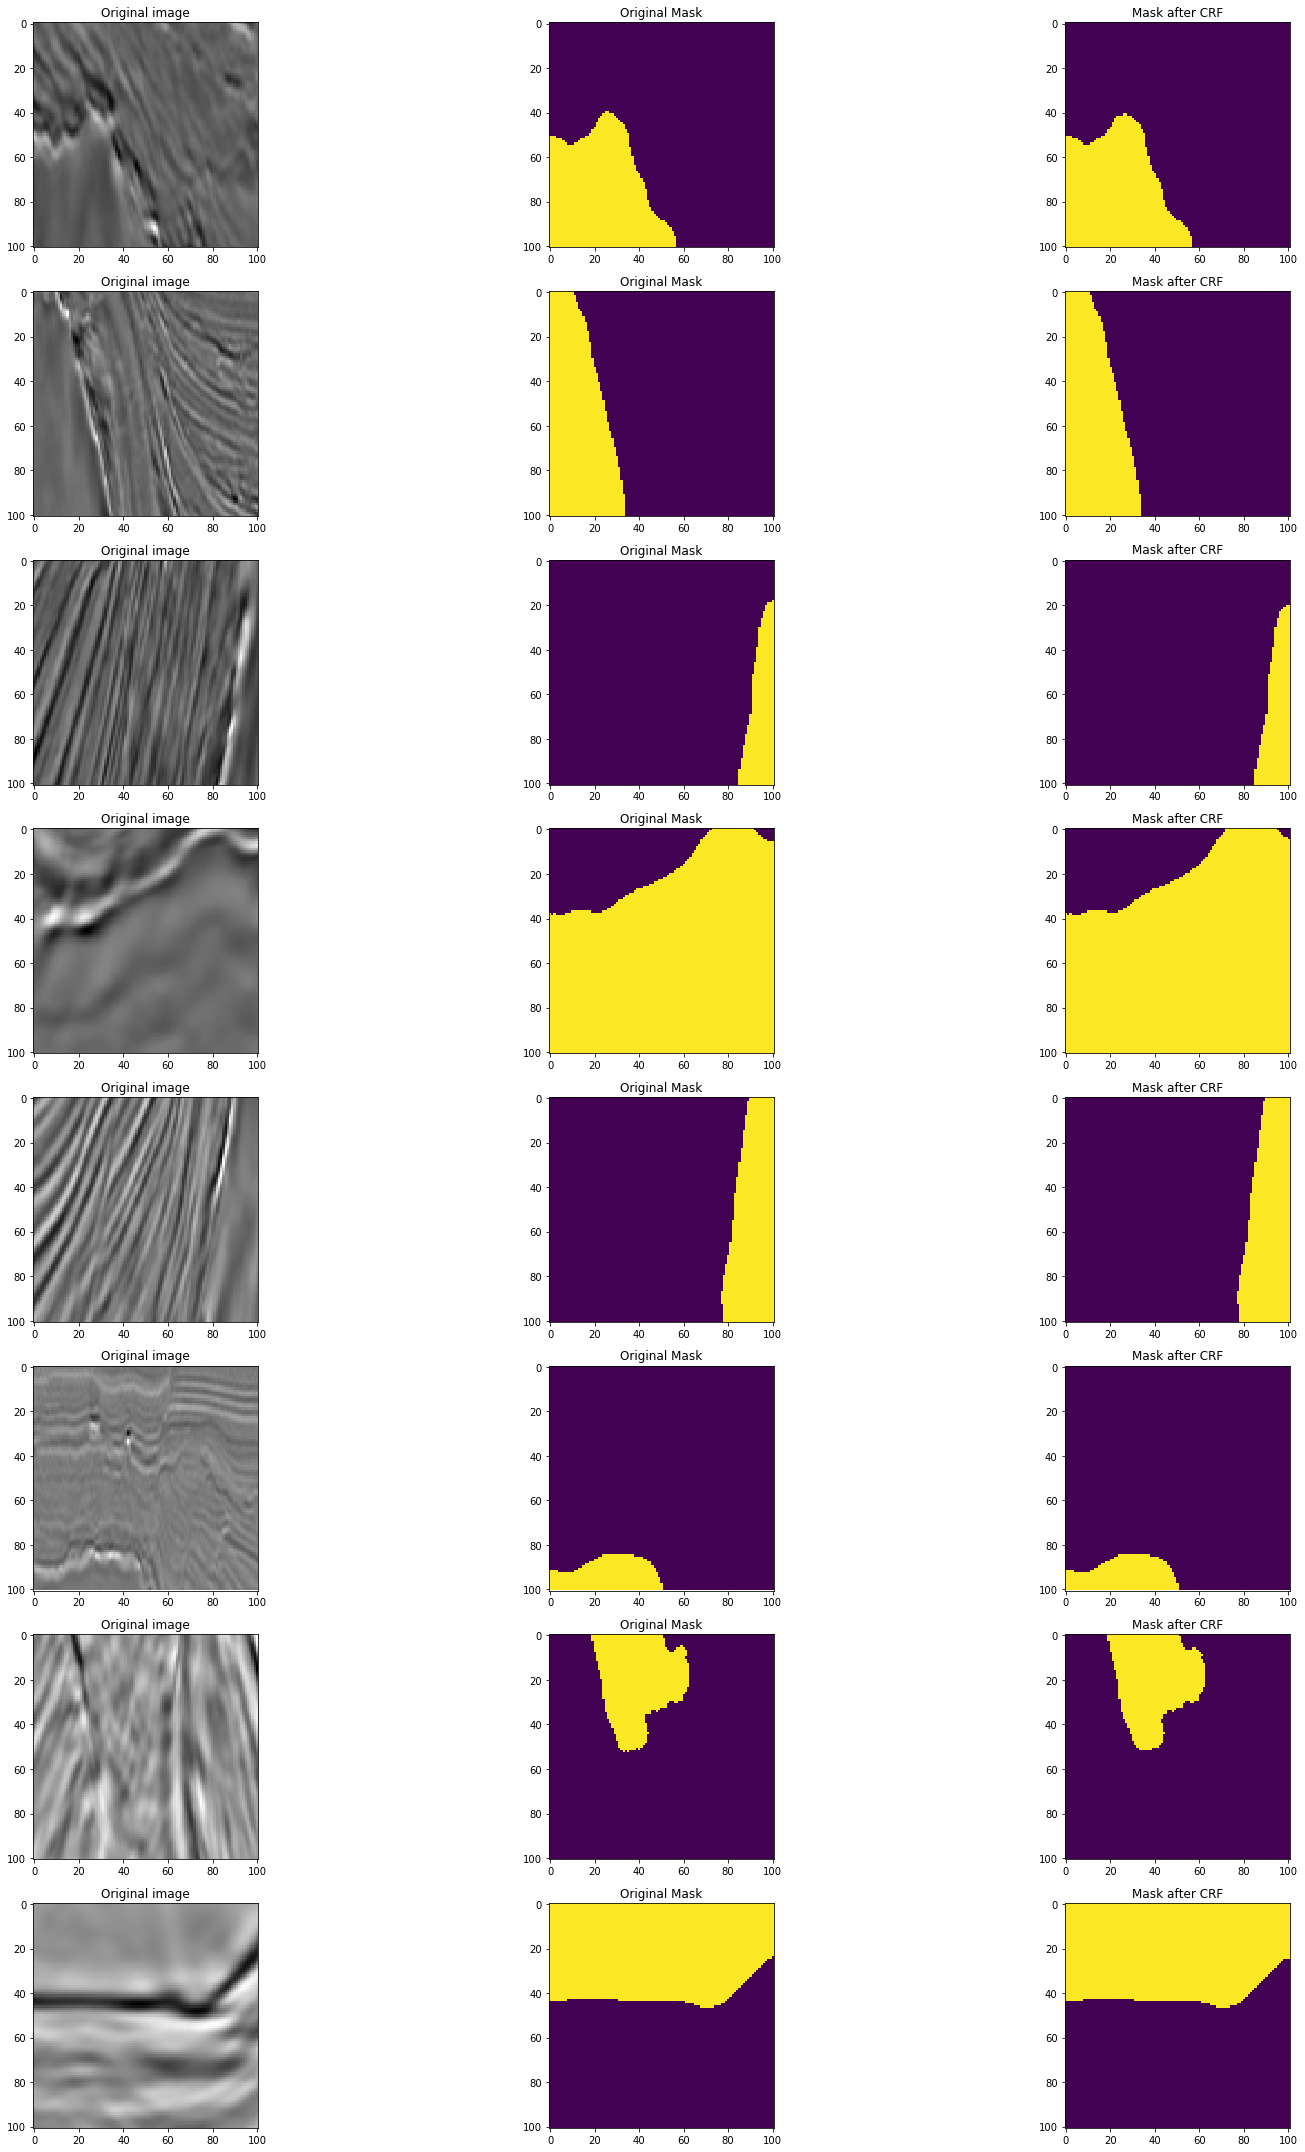

In [17]:
"""
visualizing the effect of applying CRF

"""
np.random.seed(100)
nImgs = 8
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(30,30))
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(np.fliplr(np.rot90(decoded_mask,k=3)))
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(np.fliplr(np.rot90(crf_output,k=3)))
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1
plt.tight_layout()

In [13]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [18]:
"""
used for converting the decoded image to rle mask

"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Apply CRF on all the masks

In [19]:
"""
Applying CRF on the predicted mask 

"""
df = pd.read_csv('./result/007-submission-vote-fixed.csv')

def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

for i in tqdm_notebook(range(df.shape[0])):
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')        
        crf_output = crf(orig_img, decoded_mask)
        crf_output = filter_image(crf_output)
        df.loc[i,'rle_mask'] = rle_encode(crf_output)
        
df.to_csv("./result/007-submission-vote-fixed-crf.csv",index=False)

In [20]:
df.head(10)

,id,rle_mask
0,353e010b7b,NaN
1,5439dbbddf,NaN
2,71bab9f311,NaN
3,52551f7a80,NaN
4,512d8d9997,3251 1 3349 8 3449 12 3550 17 3568 1 3651 29 3...
5,64dba827d6,NaN
6,0a3a8a5f37,NaN
7,329563756f,1 5452 5455 98 5556 97 5657 96 5758 96 5859 96...
8,f6cba2e890,NaN
9,989c646373,NaN


In [20]:
df.to_csv("./result/005-submission-crf.csv",index=False)

In [21]:
df.head(10)

,id,rle_mask
0,353e010b7b,NaN
1,5439dbbddf,NaN
2,71bab9f311,76 26 178 25 278 26 380 25 481 25 583 24 684 2...
3,52551f7a80,NaN
4,512d8d9997,1 17 102 17 203 17 304 16 405 17 506 17 607 17...
5,64dba827d6,NaN
6,0a3a8a5f37,NaN
7,329563756f,1 5553 5556 97 5657 96 5758 96 5859 95 5960 95...
8,f6cba2e890,NaN
9,989c646373,NaN


In [24]:
"""
Applying CRF on the predicted mask 

"""
df = pd.read_csv('./result/005-submission.csv')

def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

for i in tqdm_notebook(range(df.shape[0])):
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')        
        crf_output = crf(orig_img, decoded_mask)
        # crf_output = filter_image(crf_output)
        df.loc[i,'rle_mask'] = rle_encode(crf_output)
        
df.to_csv("./result/005-submission-crf-raw.csv",index=False)

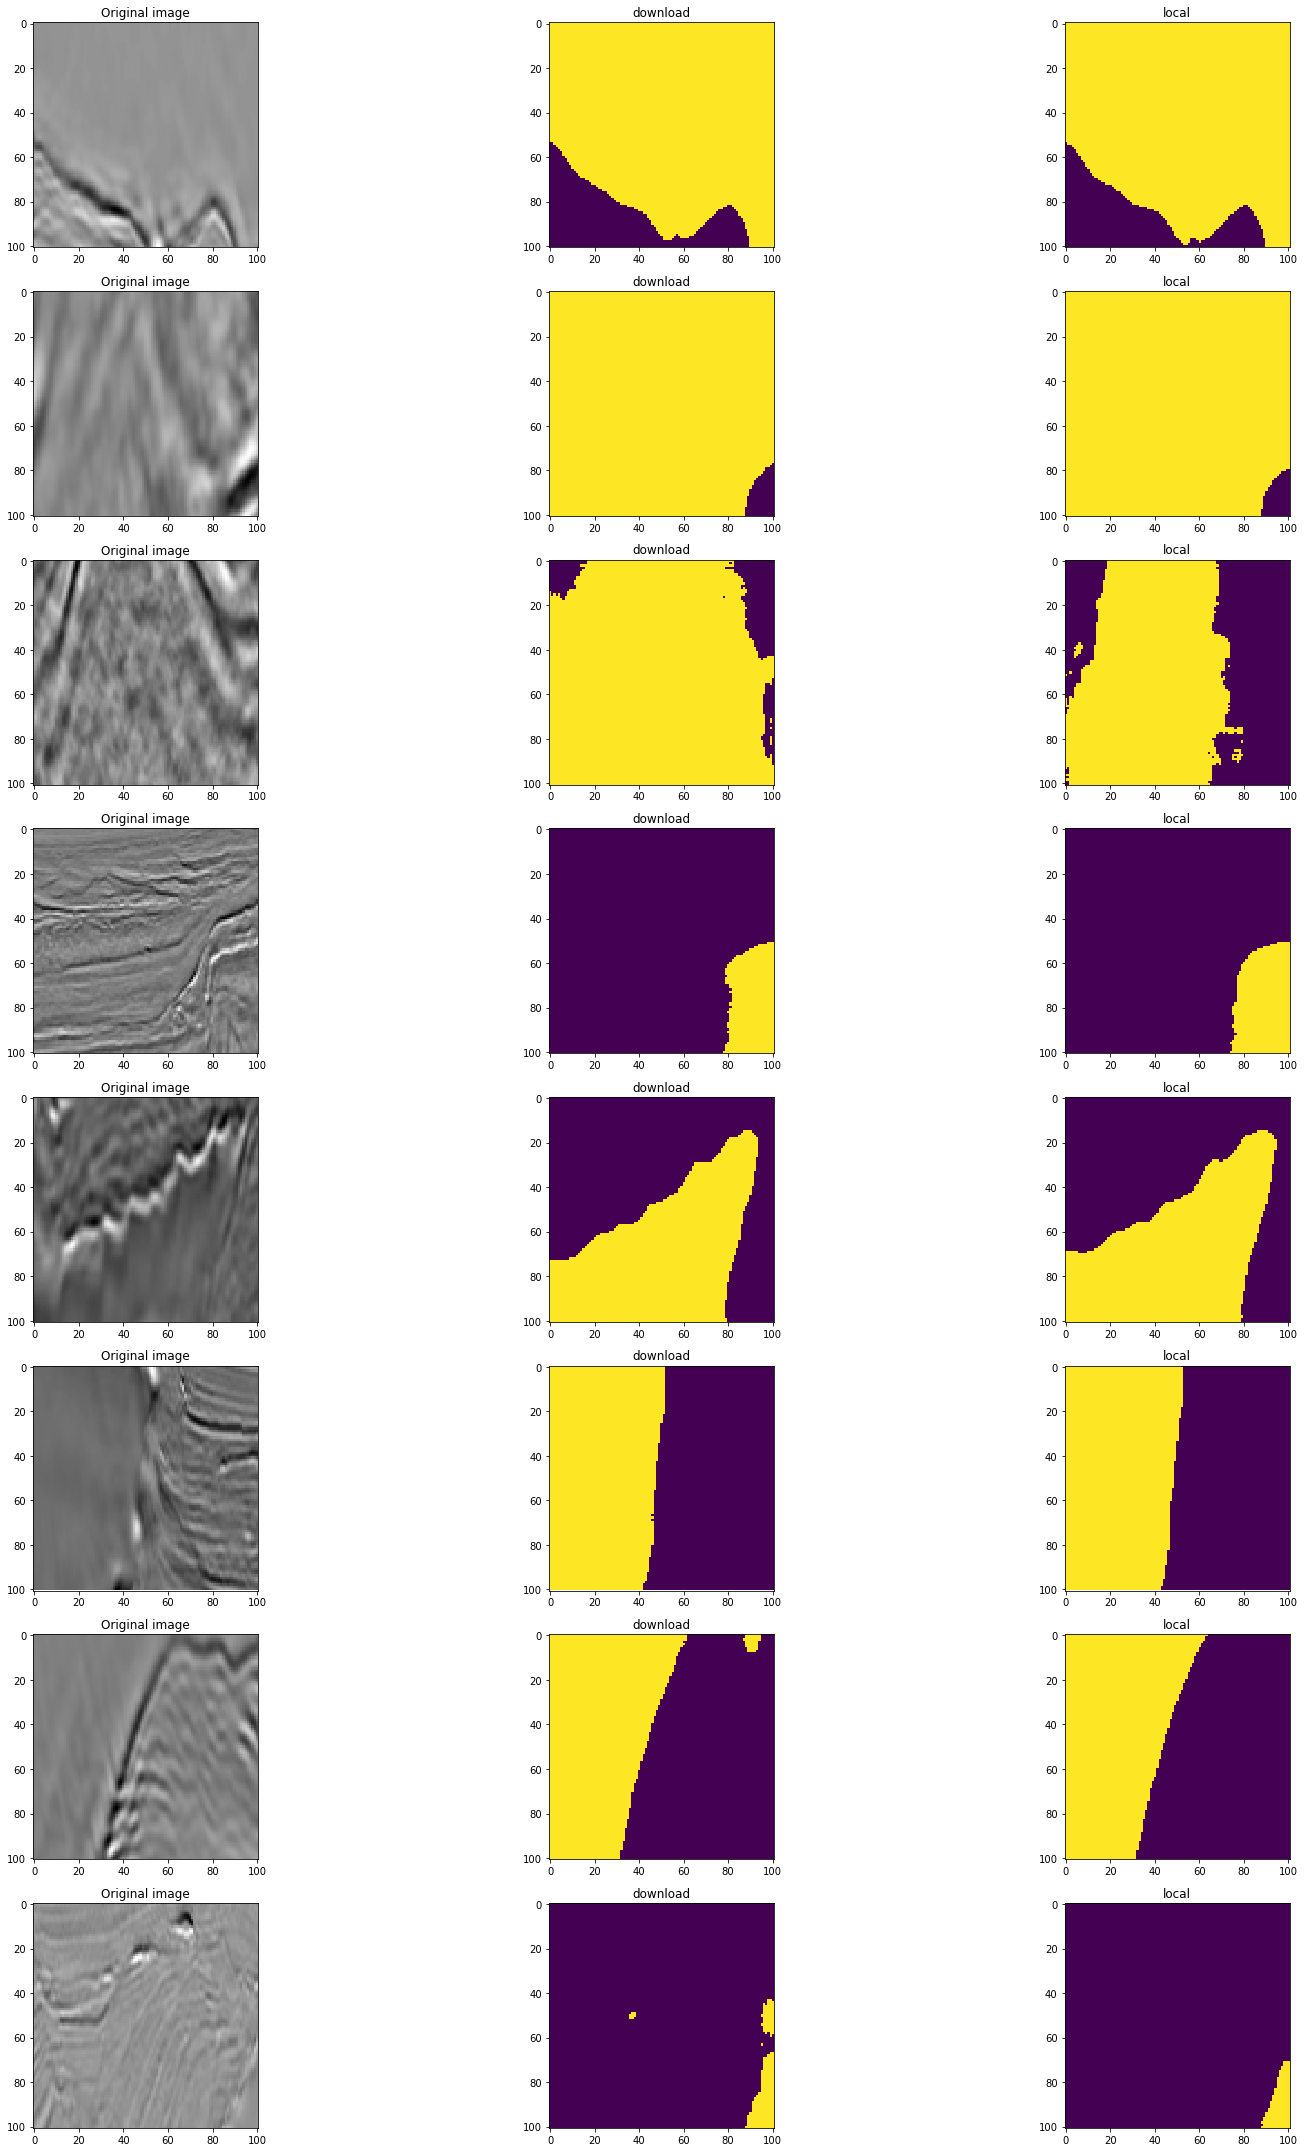

In [22]:
"""
visualizing the effect of applying CRF

"""
df1 = pd.read_csv("./download/submission.csv")
df2 = pd.read_csv("./result/007-submission-bld.csv")


np.random.seed(100)
np.random.seed(200)
np.random.seed(250)
nImgs = 8
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(30,30))
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
               
        orig_img = imread(test_path+df.loc[i,'id']+'.png')
        #Applying CRF on FCN-16 annotated image
        # crf_output = crf(orig_img,decoded_mask)
        decoded_mask = rle_decode(df1.loc[i,'rle_mask']) 
        crf_output = rle_decode(df2.loc[i,'rle_mask']) 
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(np.fliplr(np.rot90(decoded_mask,k=3)))
        plt.title('download')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(np.fliplr(np.rot90(crf_output,k=3)))
        plt.title('local')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1
plt.tight_layout()

In [40]:
df = pd.read_csv('./result/005-submission-crf-once.csv')

def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

for i in tqdm_notebook(range(df.shape[0])):
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        # crf_output = np.fliplr(np.rot90(decoded_mask,k=3))
        df.loc[i,'rle_mask'] = rle_encode(decoded_mask)
        
df.to_csv("./result/005-submission-crf-once-fliprot.csv",index=False)

In [8]:
"""
visualizing the effect of applying CRF

"""
df1 = pd.read_csv("./result/005-submission.csv")
# df2 = pd.read_csv("./result/005-submission.csv")


np.random.seed(100)
nImgs = 8
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(30,30))
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
               
        orig_img = imread(test_path+df.loc[i,'id']+'.png')
        #Applying CRF on FCN-16 annotated image
        decoded_mask = rle_decode(df1.loc[i,'rle_mask']) 
        crf_output = crf(orig_img,decoded_mask)
        # crf_output = rle_decode(df2.loc[i,'rle_mask']) 
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(np.fliplr(np.rot90(decoded_mask,k=3)))
        plt.title('773 CRF')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(np.fliplr(np.rot90(crf_output,k=3)))
        plt.title('470 CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1
plt.tight_layout()

NameError: name 'crf' is not defined